<H1 align='center'>Machine Learning</H1>

<H3>Imports</H3>

In [376]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import SGDRegressor
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.graphics.gofplots import qqplot
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

<H3>Read CSV</H3>

In [128]:
df = pd.read_csv('../Data/hour.csv')

df = df.drop('instant', axis=1)
df = df.drop('dteday', axis=1)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(11)
memory usage: 2.0 MB


<H3>Prepare Dataframe for machine learning by turning categorical values into seperate columns</H3>

In [129]:
for season in df.season.unique():
    df['season_'+str(season)] = (df['season']==season)
    
df = df.drop('season', axis=1)


for mnth in df.mnth.unique():
    df['mnth_'+str(mnth)] = (df['mnth']==mnth)
    
df = df.drop('mnth', axis=1)


for weekday in df.weekday.unique():
    df['weekday_'+str(weekday)] = (df['weekday']== weekday)
    
df = df.drop('weekday', axis = 1)


for weathersit in df.weathersit.unique():
    df['weathersit_'+str(weathersit)] = (df['weathersit']== weathersit)
    
df = df.drop('weathersit', axis=1)


for hr in df.hr.unique():
    df['hr_'+str(hr)] = (df['hr'] == hr)
    
df = df.drop('hr', axis = 1)

df['outcome'] = df['cnt']
df['casual_users'] = df['casual']
df['registered_users'] = df['registered']
df = df.drop(['cnt', 'casual', 'registered'], axis = 1)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 61 columns):
yr                  17379 non-null int64
holiday             17379 non-null int64
workingday          17379 non-null int64
temp                17379 non-null float64
atemp               17379 non-null float64
hum                 17379 non-null float64
windspeed           17379 non-null float64
season_1            17379 non-null bool
season_2            17379 non-null bool
season_3            17379 non-null bool
season_4            17379 non-null bool
mnth_1              17379 non-null bool
mnth_2              17379 non-null bool
mnth_3              17379 non-null bool
mnth_4              17379 non-null bool
mnth_5              17379 non-null bool
mnth_6              17379 non-null bool
mnth_7              17379 non-null bool
mnth_8              17379 non-null bool
mnth_9              17379 non-null bool
mnth_10             17379 non-null bool
mnth_11             17379 non-null b

<H3>Split Training Data And Test Data(70/30)</H3>

In [262]:
Xs = np.array(df.iloc[:,:-3], dtype='f')
ys =  np.array(df.iloc[:,-3:], dtype='f')

X_train, X_test,y_train,  y_test = train_test_split(Xs,ys, test_size=0.3, random_state=21)

<H3>Create New Dataframe With Training Data</H3>

In [301]:
df_train = pd.DataFrame(X_train)
df_train['total_shares'] = pd.Series(y_train[:,0])
df_train['registered_shares'] = pd.Series(y_train[:,2])
df_train['casual_shares'] = pd.Series(y_train[:,1])

cols = list(df.columns[:-3])

cols = cols + ['total_shares', 'registered_shares', 'casual_shares']

df_train.columns = cols

In [380]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,...,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,total_shares,registered_shares,casual_shares
0,1.0,0.0,1.0,0.92,0.8788,0.40,0.3582,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,688.0,615.0,73.0
1,1.0,0.0,1.0,0.64,0.6212,0.61,0.2537,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,181.0,46.0
2,0.0,0.0,1.0,0.52,0.5000,0.48,0.1045,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,176.0,29.0
3,0.0,0.0,0.0,0.24,0.2879,0.75,0.0000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.0,3.0
4,0.0,1.0,0.0,0.38,0.3939,0.37,0.4627,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,183.0,64.0


In [302]:
df_test = pd.DataFrame(X_test)
df_test['total_shares'] = pd.Series(y_test[:,0])
df_test['registered_shares'] = pd.Series(y_test[:,2])
df_test['casual_shares'] = pd.Series(y_test[:,1])
cols = list(df.columns[:-3])

cols = cols + ['total_shares', 'registered_shares', 'casual_shares']

df_test.columns = cols

In [381]:
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,...,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,total_shares,registered_shares,casual_shares
0,0.0,0.0,1.0,0.14,0.1515,0.86,0.1642,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0
1,0.0,0.0,1.0,0.16,0.1818,0.86,0.1045,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0
2,1.0,0.0,0.0,0.30,0.2879,0.33,0.2239,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,81.0,15.0
3,1.0,0.0,0.0,0.60,0.6212,0.43,0.4179,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.0,263.0,79.0
4,1.0,0.0,0.0,0.40,0.4091,0.87,0.1045,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,404.0,341.0,63.0


<H3> Fit the training Data In a OLS Linear Model</H3>

In [336]:
m = ols('total_shares ~ temp + windspeed + hum + yr + weekday_0 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6 +  weathersit_1 + weathersit_2 + weathersit_3 +  weathersit_4 + season_1  + season_2  + season_3  + season_4 + mnth_1 + mnth_2 + mnth_3  +  mnth_4 + mnth_5 + mnth_6 + mnth_7 + mnth_8  + mnth_9 + mnth_10 + mnth_11 + mnth_12 + hr_0 + hr_1 + hr_2 + hr_3 + hr_4 + hr_5 + hr_6 + hr_7 + hr_8 + hr_9 + hr_10 + hr_11 + hr_12 + hr_13 + hr_14 + hr_15 + hr_16 + hr_17 + hr_18 + hr_19 + hr_20 + hr_21 + hr_22 + hr_23 - 1',df_train).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:           total_shares   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     836.3
Date:                Mon, 21 May 2018   Prob (F-statistic):               0.00
Time:                        18:07:05   Log-Likelihood:                -61714.
No. Observations:               10970   AIC:                         1.235e+05
Df Residuals:                   10919   BIC:                         1.239e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
temp           212.5236      7.781     27.315   

<H3> Remove Outliers From Training Data</H3>

In [322]:
ol = m.outlier_test()

In [323]:
ol.head()

,student_resid,unadj_p,bonf(p)
0,1.352715,0.176172,1.0
1,-1.212323,0.225412,1.0
2,-0.174662,0.861348,1.0
3,1.227904,0.219507,1.0
4,0.561326,0.574586,1.0


In [330]:
df_train = df_train.drop(df_train[ol['unadj_p']<0.1].index, axis=0)

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<H3>Remove Most Influential Points From Training Data</H3>

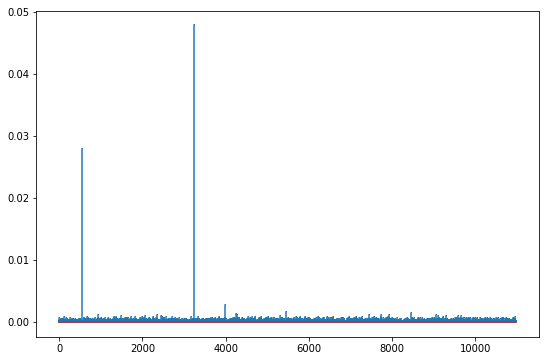

In [337]:
(c,p) = m.get_influence().cooks_distance

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.stem(np.arange(len(c)), c, markerfmt=",")

plt.show()

In [338]:
df_train = df_train.drop(df_train[c>0.0010].index, axis=0)

<H3> Total Shares - Linear Regression Model - Train R2 Score(0.79) - Test R2 Score (0.67) - MSE score (10670) </H3>

In [382]:
pipe = Pipeline([('selectKBest', SelectKBest()), ('clf', LinearRegression())])
param_grid = {
    'clf__fit_intercept' : [True, False],
    'selectKBest__k' : range(1,50,1),
    'selectKBest__score_func' : [f_regression]
}

grid =GridSearchCV(pipe, param_grid, cv=5 )
grid.fit(df_train.iloc[:,:-3].astype(float),df_train.iloc[:,-3].astype(int))

In [372]:
grid.best_score_

0.79246408355849662

In [373]:
y_pred = grid.predict(df_test.iloc[:, :-3])

In [374]:
grid.score(df_test.iloc[:, :-3], df_test.total_shares)

0.6708989447135385

In [377]:
mean_squared_error(df_test.total_shares, y_pred)

10670.342649072809

<H3> Registered Shares - Linear Regression Model - Train R2 Score(0.78) - Test R2 Score (0.67) - MSE score (7364)</H3>

In [397]:
pipe = Pipeline([('selectKBest', SelectKBest()), ('clf', LinearRegression())])
param_grid = {
    'clf__fit_intercept' : [True, False],
    'selectKBest__k' : range(1,50,1),
    'selectKBest__score_func' : [f_regression]
}

grid =GridSearchCV(pipe, param_grid, cv=5 )
grid.fit(df_train.iloc[:,:-3].astype(float),df_train.iloc[:,-2].astype(int))

In [398]:
grid.best_score_

0.77918132521124384

In [399]:
y_pred = grid.predict(df_test.iloc[:, :-3])

In [400]:
grid.score(df_test.iloc[:, :-3], df_test.registered_shares)

0.66707683434926635

In [401]:
mean_squared_error(df_test.registered_shares, y_pred)

7364.8099590485435

In [ ]:
<H3> Casual Shares - Linear Regression Model - Train R2 Score(0.62) - Test R2 Score (0.56) - MSE score (1156)</H3>

In [409]:
print('')

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-package

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/preethi.john/anaconda3/lib/python3.6/site-packages/

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('selectKBest', SelectKBest(k=10, score_func=<function f_classif at 0x114db4b70>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__fit_intercept': [True, False], 'selectKBest__k': range(1, 50), 'selectKBest__score_func': [<function f_regression at 0x114db4d08>]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [404]:
grid.best_score_

0.62856724366210415

In [405]:
y_pred = grid.predict(df_test.iloc[:, :-3])

In [395]:
grid.score(df_test.iloc[:, :-3], df_test.casual_shares)

0.56039665429562624

In [408]:
mean_squared_error(df_test.casual_shares, y_pred)

1156.470576570918